# Overlap correction
    


TODO:
- read a complete dataset
- read txt file
- apply the correction

In [196]:
import glob,sys,os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
%matplotlib inline
from astropy.io import fits


In [198]:
%pwd
folder = '/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066'
folder_output = '/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/Corrected_withPandas'
sorted_fits= sorted(glob.glob(folder+'/*.fits'))[:-2]
sorted_TXT= sorted(glob.glob(folder+'/*.txt'))
display(sorted_TXT)
num_windows = 5

if not os.path.exists(folder_output):
    os.makedirs(folder_output)

['/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_ShutterCount.txt',
 '/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_ShutterTimes.txt',
 '/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_Spectra.txt',
 '/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_Status.txt']

,Counts
0,78847
1,79115
2,79659
3,79293
4,79086


array([ 0.007     ,  0.00180224,  0.00031808,  0.003072  ,  0.000348  ,
        0.00305152,  0.00034848,  0.00606208,  0.00033792,  0.0136397 ])

0.007
0.00180224
0.00031808
0.003072
0.000348
0.00305152
0.00034848
0.00606208
0.00033792
0.0136397


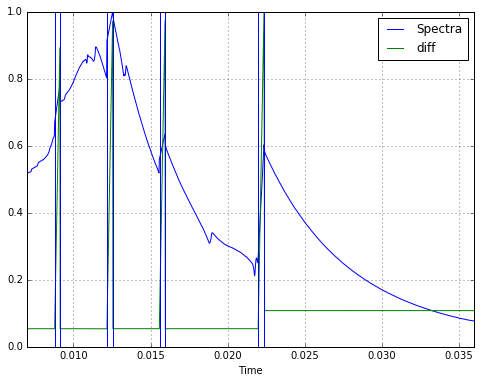

array([ 0.007     ,  0.00880224,  0.00912032,  0.01219232,  0.01254032,
        0.01559184,  0.01594032,  0.0220024 ,  0.02234032,  0.03598002])

{0: (0.0069999999999999993, 0.0088022399999999994),
 1: (0.0091203199999999995, 0.01219232),
 2: (0.012540319999999999, 0.015591839999999999),
 3: (0.015940320000000001, 0.022002400000000002),
 4: (0.02234032, 0.035980020000000001)}

(4, 79086)

In [136]:
df = pd.read_csv( '/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_Spectra.txt',delim_whitespace=True,header=None,
                names=['Time','Spectra'])
df['diff']=df['Time'].diff()
df['Spectra']= df['Spectra']/df['Spectra'].max()
df['diff']= df['diff']/df['diff'].max()

df_shutterTime = pd.read_csv('/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_ShutterTimes.txt',delim_whitespace=True,header=None,
                             names=['t0','t1'], nrows=num_windows)

df_shutterCount = pd.read_csv('/data/data2/RADEN_Feb2018/04_i_OB/TEST5_066/TEST5_066_ShutterCount.txt',delim_whitespace=True,header=None,
                             names=['Counts'], nrows=num_windows, index_col=0)

display(df_shutterCount)


df_shutterTime=np.asarray(df_shutterTime.stack(level=[0]))

display(df_shutterTime)
df.plot(x='Time',y=['Spectra','diff'],grid=True,figsize=(8,6))
sumTime = 0
TimeArray = np.zeros(num_windows*2)
index=0
for i in df_shutterTime:
    print(i)
    sumTime += i
    TimeArray[index] = sumTime
    index += 1
    plt.axvline(x=sumTime)


plt.show()
display(TimeArray)
interval = {int(key):(value1,value2) for key,value1,value2 in zip(range(len(TimeArray)),TimeArray[::2],TimeArray[1::2])}
display(interval)
def interAssig(value,intervalDict,df_shutterCount):
    for keyInt in intervalDict:
        if intervalDict[keyInt][0]<= value <=intervalDict[keyInt][1]:
            return keyInt,df_shutterCount['Counts'][keyInt]
interAssig(0.0271,interval,df_shutterCount)

In [201]:
dfName = pd.DataFrame(sorted_fits,columns=['name'])
dfName['ToF'] = df['Time']
dfName['ShutterWindow']= dfName['ToF'].apply(lambda i:interAssig(i,interval,df_shutterCount))

display(dfName.iloc[0,2][1])

# display(dfName)

for i in dfName.groupby('ShutterWindow'):
    display(i[0])
    array = i[1]['name'].apply(lambda i:fits.open(i)[0].data).as_matrix()
#     array = array.reshape(len(array),np.shape(array[0])[0],np.shape(array[0])[1])
#     display(type(array),np.shape(array))
    sumim=np.zeros(np.shape(array[0]))
    
    for j in range(0,len(array)):
        sumim+=array[j]
#         display(sumim)
        
        if j==0:
            P=0
        else:
            P=sumim/i[0][1]
            
        newim = array[j]/(1-P)
        newim= newim.astype(float)
        fits.writeto(folder_output+'/'+str(i[0][0])+str(j).zfill(5)+'.fits',newim)
        
        
        

    

78847

(0, 78847)

(1, 79115)

(2, 79659)

(3, 79293)

(4, 79086)